# DNN CIC-IDS-2017

La última fase de la evaluación conlleva la evaluación de los modelos en dominios similares. Para ello, se utilizó el CIC-IDS-2017, el conjunto de datos predecesor del utilizado en  este proyecto. A continuación se muestran las
métricas y el porcentaje de ataques detectados para la técnica de DNN.

## Librerías necesarias

In [1]:
import gc
import math
import pandas as pd
from glob import glob
from os import getcwd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import sklearn
import keras
from sklearn.metrics import f1_score, make_scorer
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

pd.set_option("display.max_columns", 80)

In [2]:
import itertools
def plot_confusion_matrix(cm, title, classes=['normal', 'abnormal'], save=False, save_as='MyFigure.png', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.1%'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i,j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if save:
        plt.savefig(save_as, dpi=100)

## Carga del modelo

In [4]:
dnn = tf.keras.models.load_model('/home/jovyan/My-Notebooks/Signature Detection/dnn-arch')

In [5]:
dnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 22)                0         
                                                                 
 dense_2 (Dense)             (None, 448)               10304     
                                                                 
 dense_3 (Dense)             (None, 384)               172416    
                                                                 
 dense_4 (Dense)             (None, 480)               184800    
                                                                 
 dense_5 (Dense)             (None, 160)               76960     
                                                                 
 dropout_1 (Dropout)         (None, 160)               0         
                                                                 
 dense_6 (Dense)             (None, 7)                

### Carga del conjunto de datos

In [8]:
df = pd.read_csv('/home/jovyan/CIC-IDS-2017/CIC-IDS-2017-train.csv', sep=',', low_memory=False)
y_train = df.pop('Label')
X_train = df.values

### Entrenamiento

In [9]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)
dnn.fit(X_train, y_train, epochs=500, callbacks=[stop_early], shuffle=True)

Epoch 1/500
21875/21875 [==============================] - 98s 4ms/step - loss: 0.1185 - accuracy: 0.1290
Epoch 2/500
21875/21875 [==============================] - 97s 4ms/step - loss: 0.0746 - accuracy: 0.1333
Epoch 3/500
21875/21875 [==============================] - 97s 4ms/step - loss: 0.0646 - accuracy: 0.1341
Epoch 4/500
21875/21875 [==============================] - 97s 4ms/step - loss: 0.0553 - accuracy: 0.1347
Epoch 5/500
21875/21875 [==============================] - 97s 4ms/step - loss: 0.0512 - accuracy: 0.1352
Epoch 6/500
21875/21875 [==============================] - 98s 4ms/step - loss: 0.0494 - accuracy: 0.1354
Epoch 7/500
21875/21875 [==============================] - 98s 4ms/step - loss: 0.0464 - accuracy: 0.1354
Epoch 8/500
21875/21875 [==============================] - 97s 4ms/step - loss: 0.0449 - accuracy: 0.1355
Epoch 9/500
21875/21875 [==============================] - 97s 4ms/step - loss: 0.0436 - accuracy: 0.1357
Epoch 10/500
21875/21875 [====================

In [10]:
df = pd.read_csv('/home/jovyan/CIC-IDS-2017/CIC-IDS-2017-test.csv', sep=',', low_memory=False)
y_test = df.pop('Label')
X_test = df.values

In [11]:
%%time
predictions = dnn.predict(X_test)

25429/25429 [==============================] - 45s 2ms/step
CPU times: user 1min 19s, sys: 12.3 s, total: 1min 31s
Wall time: 49.1 s


In [12]:
predictions = predictions.argmax(axis=1)

In [13]:
print(classification_report(y_test, predictions, digits=5))

              precision    recall  f1-score   support

           0    0.99971   0.95582   0.97727    647015
           1    0.93311   0.99775   0.96435    113868
           2    0.83092   0.99686   0.90636     47805
           3    0.09292   0.98938   0.16988       565
           4    0.72936   0.99927   0.84324      4094
           5    0.00417   0.66667   0.00829         9
           6    0.12249   0.98901   0.21798       364

    accuracy                        0.96435    813720
   macro avg    0.53038   0.94211   0.58391    813720
weighted avg    0.97808   0.96435   0.96971    813720



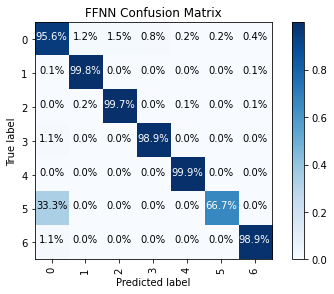

In [14]:
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, title='FFNN Confusion Matrix', classes=['0', '1', '2', '3', '4', '5', '6'])

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

def kfold(model, X, y):
    scores = []
    skfold = StratifiedKFold(n_splits = 4)

    for train_index, test_index in skfold.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)

        scores.append(accuracy_score(y_test, model.predict(X_test).argmax(axis=1)))
    return scores

In [16]:
results = kfold(dnn, X_train, y_train)
np.mean(results)

5469/5469 [==============================] - 11s 2ms/step


0.99084